In [1]:
# import packages - \src\utils\start_wrapper.py
from src.utils.start_wrapper import *
wrapper_notebook_settings()

# Load dictionary of project paths
import src.utils.paths
paths = src.utils.paths.paths_dictionary()
print("Contents of paths dictionary:")
for key in paths:
    print(key, ": ", paths[key])


#  basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Load environment variables
import dotenv
import os
dotenv.load_dotenv(os.path.join(os.path.dirname(os.getcwd()), '.env'))

# project specific packages
import urllib.request
import seaborn as sns
import sklearn as sk
from sklearn import metrics
from prophet import Prophet

Contents of paths dictionary:
data :  /app/data/
docs :  /app/docs/
models :  /app/models/
notebooks :  /app/notebooks/
references :  /app/references/
reports :  /app/reports/
src :  /app/src/
app :  /app/
data_external :  /app/data/external/
data_interim :  /app/data/interim/
data_processed :  /app/data/processed/
data_raw :  /app/data/raw/
reports_figures :  /app/reports/figures/
src_data :  /app/src/data/
src_features :  /app/src/features/
src_models :  /app/src/models/
src_utils :  /app/src/utils/
src_visualization :  /app/src/visualization/


In [2]:
# Parameters section

seed = 123 # random seed for reproducibility of results
forecast_days = 7 # number of days to forecast

In [3]:
# Kids, don't do this at home
os.environ['secret_apiKey']

'S0_S3cR3T'

In [4]:
def stooqData(ticker: str):
    url = f"https://stooq.com/q/d/l/?s={ticker}&i=d"
    data = pd.read_csv(url)
    data.columns = [col.lower() for col in data.columns]
    data['date'] = pd.to_datetime(data['date'])
    return data

# if you're reading this carved out in stone in front of a cave, I am sorry. You have to be connected to the Internet to download data from the web.

In [5]:
aapl = stooqData('aapl.us')
aapl

,date,open,high,low,close,volume
0,1984-09-07,0.100763,0.101999,0.099546,0.100763,9.767604e+07
1,1984-09-10,0.100763,0.101071,0.098340,0.100165,7.581254e+07
2,1984-09-11,0.101071,0.103814,0.101071,0.101999,1.787705e+08
3,1984-09-12,0.101999,0.102597,0.098928,0.098928,1.561713e+08
4,1984-09-13,0.104432,0.104730,0.104432,0.104432,2.432310e+08
...,...,...,...,...,...,...
9941,2024-02-20,181.790000,182.430000,180.000000,181.560000,5.366555e+07
9942,2024-02-21,181.940000,182.888800,180.660000,182.320000,4.152967e+07
9943,2024-02-22,183.480000,184.955000,182.460000,184.370000,5.229221e+07
9944,2024-02-23,185.010000,185.040000,182.230000,182.520000,4.511968e+07


In [6]:
aapl[(aapl["date"].dt.year == 2005) & (aapl["date"].dt.month == 2)]

,date,open,high,low,close,volume
5147,2005-02-01,1.17272,1.18379,1.16565,1.18040,7.963372e+08
5148,2005-02-02,1.18728,1.21619,1.18249,1.21190,1.201629e+09
5149,2005-02-03,1.20612,1.20931,1.17701,1.18458,8.594766e+08
5150,2005-02-04,1.18728,1.20154,1.18040,1.20004,6.611406e+08
5151,2005-02-07,1.20254,1.20772,1.17960,1.20154,6.159255e+08
5152,2005-02-08,1.20522,1.23873,1.19944,1.23135,1.044301e+09
5153,2005-02-09,1.23593,1.24799,1.18888,1.19844,1.400187e+09
5154,2005-02-10,1.19874,1.20672,1.16684,1.19276,1.282334e+09
5155,2005-02-11,1.21709,1.24451,1.20154,1.23593,1.409609e+09
5156,2005-02-14,1.25946,1.29086,1.24889,1.28817,1.492042e+09


In [7]:
train = aapl[['date', 'close']][:-forecast_days].copy()  # All data except the last 7 observations
train.columns = ['ds', 'y']  # Renaming columns to fit Prophet's requirements
display('train dataset size:', train.shape)
test = aapl[['date', 'close']][-forecast_days:].copy()   # Last 7 observations
test.columns = ['ds', 'y']  # Renaming columns to fit Prophet's requirements
display('train dataset size:', test.shape)

'train dataset size:'

(9939, 2)

'train dataset size:'

(7, 2)

In [8]:
train.tail()

,ds,y
9934,2024-02-08,188.32
9935,2024-02-09,188.85
9936,2024-02-12,187.15
9937,2024-02-13,185.04
9938,2024-02-14,184.15


In [9]:
test

,ds,y
9939,2024-02-15,183.86
9940,2024-02-16,182.31
9941,2024-02-20,181.56
9942,2024-02-21,182.32
9943,2024-02-22,184.37
9944,2024-02-23,182.52
9945,2024-02-26,181.16


In [10]:
# Train forecasting model
m = Prophet()
m.fit(train)

07:49:22 - cmdstanpy - INFO - Chain [1] start processing
07:49:27 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Python
future = m.make_future_dataframe(periods=2*forecast_days) # 2*forecast_days to include weekends
future = future[future['ds'].dt.dayofweek < 5] # exclude weekends
future.tail(10)

,ds
9939,2024-02-15
9940,2024-02-16
9943,2024-02-19
9944,2024-02-20
9945,2024-02-21
9946,2024-02-22
9947,2024-02-23
9950,2024-02-26
9951,2024-02-27
9952,2024-02-28


In [12]:
# Predict the future
np.random.seed(123) # for reproducibility of results
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9944,2024-02-22,184.624546,174.434200,195.029077
9945,2024-02-23,184.545292,174.611694,195.354446
9946,2024-02-26,184.615104,174.388856,194.597180
9947,2024-02-27,184.643966,175.173696,193.854156
9948,2024-02-28,184.682515,174.126126,194.459966


In [13]:
def identify_primary_key(df):
    for col in df.columns:
        if df[col].is_unique:
            print(f"The primary key for the DataFrame is: {col}")
            return col
    print("No primary key found.")
    return None

identify_primary_key(forecast)

The primary key for the DataFrame is: ds


'ds'

In [14]:
def get_column_types(df):
    types = df.dtypes
    print("Data Types for Each Column:")
    print(types)

get_column_types(aapl)
get_column_types(forecast)

Data Types for Each Column:
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume           float64
dtype: object
Data Types for Each Column:
ds                            datetime64[ns]
trend                                float64
yhat_lower                           float64
yhat_upper                           float64
trend_lower                          float64
trend_upper                          float64
additive_terms                       float64
additive_terms_lower                 float64
additive_terms_upper                 float64
weekly                               float64
weekly_lower                         float64
weekly_upper                         float64
yearly                               float64
yearly_lower                         float64
yearly_upper                         float64
multiplicative_terms                 float64
multiplicative_terms_lower           float64
multiplicative_

In [15]:
test

,ds,y
9939,2024-02-15,183.86
9940,2024-02-16,182.31
9941,2024-02-20,181.56
9942,2024-02-21,182.32
9943,2024-02-22,184.37
9944,2024-02-23,182.52
9945,2024-02-26,181.16


In [16]:
test_forecast = test.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
test_forecast.tail()

,ds,y,yhat,yhat_lower,yhat_upper
2,2024-02-20,181.56,184.627937,174.732688,194.608663
3,2024-02-21,182.32,184.660721,174.824170,195.603880
4,2024-02-22,184.37,184.624546,174.434200,195.029077
5,2024-02-23,182.52,184.545292,174.611694,195.354446
6,2024-02-26,181.16,184.615104,174.388856,194.597180


In [17]:
full_sample = pd.concat([train, test_forecast], ignore_index=True, sort=False)
full_sample = full_sample[full_sample['y'].notnull()] # remove rows without ground truth

In [18]:
full_sample.tail(2*forecast_days)

,ds,y,yhat,yhat_lower,yhat_upper
9932,2024-02-06,189.30,NaN,NaN,NaN
9933,2024-02-07,189.41,NaN,NaN,NaN
9934,2024-02-08,188.32,NaN,NaN,NaN
9935,2024-02-09,188.85,NaN,NaN,NaN
9936,2024-02-12,187.15,NaN,NaN,NaN
9937,2024-02-13,185.04,NaN,NaN,NaN
9938,2024-02-14,184.15,NaN,NaN,NaN
9939,2024-02-15,183.86,184.565643,174.529773,195.106643
9940,2024-02-16,182.31,184.504351,174.144795,194.517634
9941,2024-02-20,181.56,184.627937,174.732688,194.608663


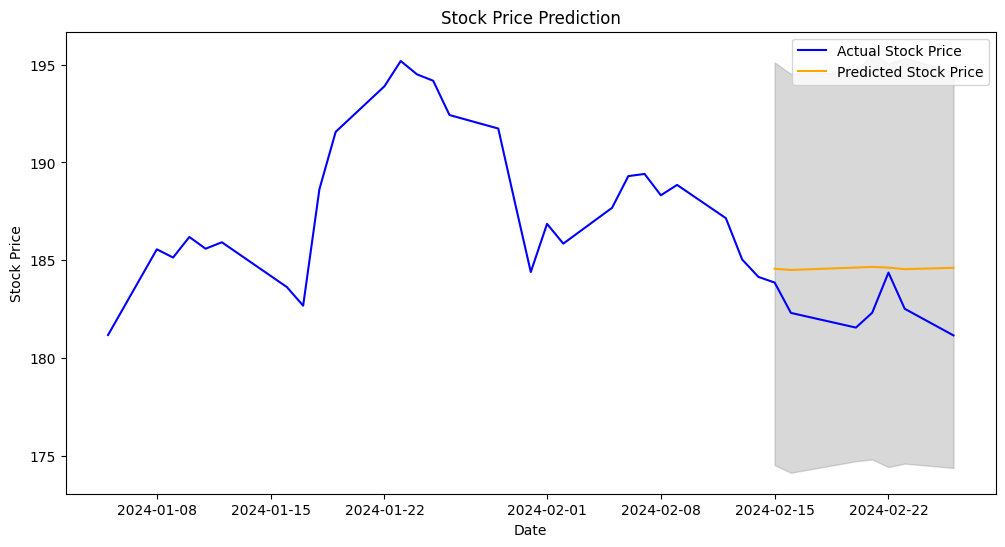

In [19]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(full_sample['ds'][-5*forecast_days:], full_sample['y'][-5*forecast_days:], label='Actual Stock Price', color='blue')
plt.plot(full_sample['ds'][-5*forecast_days:], full_sample['yhat'][-5*forecast_days:], label='Predicted Stock Price', color='orange')

# Shading the area for prediction intervals
# Assuming the last 7 observations have the forecast data
plt.fill_between(full_sample['ds'][-7:], full_sample['yhat_lower'][-forecast_days:], full_sample['yhat_upper'][-forecast_days:], color='gray', alpha=0.3)

# Adding labels, title and legend
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()

# Show the plot
plt.show()

In [20]:
# Export full dataset
full_sample.to_csv(paths['data_processed']+'forecast_full_sample.csv', index=False) 

In [21]:
# image of a poor prophet
# bad prophet, bad

In [23]:
full_sample['y']

0         0.100763
1         0.100165
2         0.101999
3         0.098928
4         0.104432
           ...    
9941    181.560000
9942    182.320000
9943    184.370000
9944    182.520000
9945    181.160000
Name: y, Length: 9946, dtype: float64

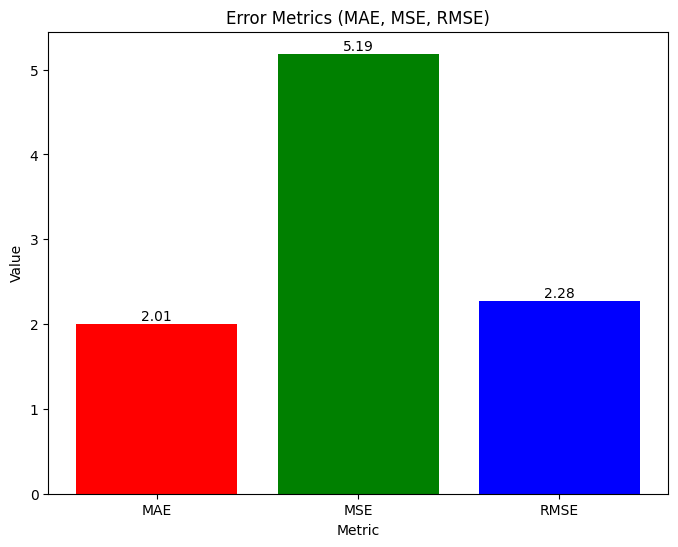

In [24]:
# Assuming 'full_sample' is your DataFrame with the actual and predicted values
# And you're focusing on the last 40 observations
actual = full_sample[full_sample['yhat'].notnull()]['y']
predicted = full_sample[full_sample['yhat'].notnull()]['yhat']

# Calculate MAE, MSE, and RMSE
mae = sk.metrics.mean_absolute_error(actual, predicted)
mse = sk.metrics.mean_squared_error(actual, predicted)
rmse = np.sqrt(mse) # RMSE is the square root of MSE

# Metrics and their names
metrics = [mae, mse, rmse]
metric_names = ['MAE', 'MSE', 'RMSE']

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(metric_names, metrics, color=['red', 'green', 'blue'])

# Adding the value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Error Metrics (MAE, MSE, RMSE)')

# Saving the plot
plt.savefig(paths['reports_figures']+'error_metrics.png')
# Show the plot
plt.show()



In [25]:
# Python serializing
# For prophet there can be problems with pickling -> hence we use serialization
from prophet.serialize import model_to_json, model_from_json

with open(paths['models']+'m001_tg_appl.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [26]:
with open(paths['models']+'m001_tg_appl.json', 'r') as fin:
    m_test = model_from_json(fin.read())  # Load model

In [27]:
np.random.seed(123) # for reproducibility of results
forecast_check = m_test.predict(future)

# Assuming df1 and df2 are your DataFrames
import pandas.testing
try:
    pandas.testing.assert_frame_equal(forecast, forecast_check)
    are_completely_same = True
except AssertionError:
    are_completely_same = False
print(f"Are the two DataFrames the same? {are_completely_same}")

# confidence intervals yhat_lower and yhat_upper are different due to the randomness of the model
#
#

Are the two DataFrames the same? True


https://github.com/facebook/prophet/issues/1124

Stochasticity comes in the prediction stage, and derives entirely from the trend uncertainty estimation. Increasing uncertainty_samples reduces variance in yhat_upper but it is still stochastic.